### This file is used as a test for later formal/extensive simulations

### Generate data by 

X <- mu_x+ BX +error + delta, 

or

X = (I-B)^{-1}* (mu_x + error + delta), 

with different kinds of B.

In [1]:
import numpy as np
import pandas as pd
from scipy import linalg
from postTranslationCode import *
from tqdm import tqdm
import networkx as nx # draw DAG

In [2]:
################### Randomly generate lower triangular matrix B
def B_random(p, s_B, B_value_min, B_value_max):
    lowertri_index = np.nonzero(np.tril(np.ones((p,p)),-1))
    num_lowertri_entry = len(lowertri_index[0])
    num_nonzero_entry = int(s_B * num_lowertri_entry)
    nonzero_index = np.random.choice(num_lowertri_entry, num_nonzero_entry, replace=False)
    B = np.zeros((p,p))
    B[lowertri_index[0][nonzero_index], lowertri_index[1][nonzero_index]] = np.random.uniform(B_value_min, B_value_max, num_nonzero_entry)

    return B

################### Randomly generate lower triangular matrix B corresponds to a hub graph
def B_hub_func(num_hub, size_up_block, size_low_block, intersect_prop, s_B, B_value_min, B_value_max):
    if num_hub < 2:
        intersect_prop = 0
    p = num_hub + num_hub * (size_up_block + size_low_block)
    B = np.zeros((p, p))
    B_upper_list, B_lower_list, hub_B_in_vec, hub_B_out_vec = [], [], [], []
    hub_size_in = size_up_block+int(size_up_block*intersect_prop) # point to hubs
    hub_size_out = size_low_block+int(size_low_block*intersect_prop) # hubs point to other nodes
    
    for i in range(num_hub):
        B_upper_list.append(B_random(size_up_block, s_B, B_value_min, B_value_max))
        B_lower_list.append(B_random(size_low_block, s_B, B_value_min, B_value_max))        
        hub_B_in_vec.append(np.random.uniform(B_value_min, B_value_max, hub_size_in))
        hub_B_out_vec.append(np.random.uniform(B_value_min, B_value_max, hub_size_out))
    
    for i in range(num_hub):
        start_index_up = i*size_up_block
        B[start_index_up:(start_index_up+size_up_block), start_index_up:(start_index_up+size_up_block)] = B_upper_list[i]
    
    for i in range(num_hub):
        start_index_in_row = num_hub*size_up_block+i
        start_index_in_col = max(0, i*size_up_block - int(size_up_block*intersect_prop))
        B[start_index_in_row, start_index_in_col:(start_index_in_col+len(hub_B_in_vec[i]))] = hub_B_in_vec[i]
    
        start_index_out_row = num_hub*size_up_block+num_hub + max(0, i*size_low_block - int(size_low_block*intersect_prop))
        start_index_out_col = num_hub*size_up_block+i
        B[start_index_out_row:(start_index_out_row+len(hub_B_out_vec[i])), start_index_out_col] = hub_B_out_vec[i]
    
    for i in range(num_hub):
        start_index_low = num_hub*size_up_block + num_hub + i*size_low_block
        B[start_index_low:(start_index_low+size_low_block), start_index_low:(start_index_low+size_low_block)] = B_lower_list[i]
    
    return B

################ Rescale B, but keep its support, so that the variance of X is close to the given one 
def rescale_B_func(B, var_X_design, sigma2_error, tol, step_size, max_count):
    p = B.shape[1]
    I = np.identity(p)
    
    var_X_ori = np.diag( np.dot( linalg.solve(I - B, np.diag(sigma2_error)), linalg.inv(I - B).T ) )

    for i in range(p):
        if np.sum(B[i]) == 0: 
            sigma2_error[i] = var_X_design[i]
        elif np.sum(B[i]) > 0:  # if not a source node
            count_while = 0
            rescale_temp = np.sqrt(np.abs(var_X_ori[i] - sigma2_error[i]))
            B_temp = B.copy()
            
            IB_inv_temp = linalg.solve(I - B_temp, np.eye(p))
            var_temp = (IB_inv_temp[i] * sigma2_error) @ IB_inv_temp[i].T

            while abs(var_temp - var_X_design[i]) > tol:
                if var_temp - var_X_design[i] > 0:
                    rescale_temp = rescale_temp * (1 + step_size)
                    B_temp = B.copy()
                    B_temp[i] = B_temp[i]/rescale_temp

                    IB_inv_temp = linalg.solve(I - B_temp, np.eye(p))
                    var_temp = (IB_inv_temp[i] * sigma2_error) @ IB_inv_temp[i].T

                if var_temp - var_X_design[i] < 0:
                    rescale_temp = rescale_temp * (1 - step_size)
                    B_temp = B.copy()
                    B_temp[i] = B_temp[i]/rescale_temp

                    IB_inv_temp = linalg.solve(I - B_temp, np.eye(p))
                    var_temp = (IB_inv_temp[i] * sigma2_error) @ IB_inv_temp[i].T

                count_while += 1
                if count_while > max_count:
                    break
            
            B = B_temp  # update B

    return B, sigma2_error

# Generate n observartional data and m interventional data

def generate_data(n, m, p, B, sigma2_error, b, int_mean, int_sd):
    # True root causes
    RC = np.random.choice(np.arange(p), size=m, replace=True)
    I = np.identity(p)
    
    X_obs = np.zeros((n,p))
    X_int = np.zeros((m,p))
    for i in range(n):
        error = np.random.multivariate_normal(np.repeat(0, p), sigma2_error, 1)
        X_obs[i,:] = linalg.solve(I - B, (b + error).T).reshape(p)
    for i in range(m):
        delta = np.repeat(0, p)
        delta[RC[i]] = np.random.normal(int_mean, int_sd, 1)
        error = np.random.multivariate_normal(np.repeat(0, p), sigma2_error, 1)
        X_int[i,:] = linalg.solve(I - B, (b + error + delta).T).reshape(p)
    
    return X_obs, X_int, RC

################### Randomly generate lower triangular matrix B corresponds to a hub graph


### Random DAG case

[6.10630475 8.46083352 4.27885445 9.94276517 9.0786026  7.9780908
 8.16117698 5.40660417 6.64180264 8.70277689]
[6.10630475 8.39225184 5.60113311 5.33970397 8.92194824 6.25414287
 8.50672619 6.3762923  7.13543425 9.45644189]


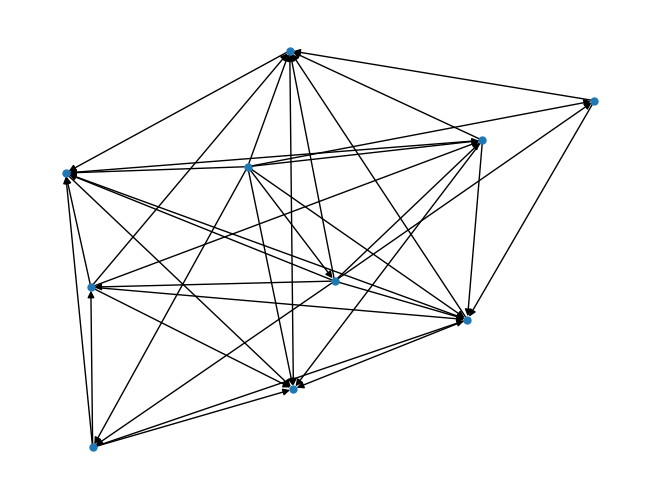

In [57]:
############## Generate b, B and sigma2_error used in the SEM
p = 10
int_mean = 20
int_sd = 1
s_B = 0.8
B_value_min = -1
B_value_max = 1

b = np.random.uniform(-5,5,p)  # intercept

B_unscaled = B_random(p, s_B, B_value_min, B_value_max)

################ Rescale B, but keep its support, so that the variance of X is close to the given one 
var_err_min = 1
var_err_max = 2
var_X_min = 5
var_X_max = 10

sigma2_error_raw = np.random.uniform(var_err_min, var_err_max, p) # rep(var_error,p) # do not make error variance the same!
var_X_design = np.random.uniform(var_X_min, var_X_max, p)  # preset variance of X we want to get based on the SEM
B_raw, sigma2_error_new = rescale_B_func(B_unscaled, var_X_design, sigma2_error_raw, tol=1, step_size=0.3, max_count=30)

# # check that we indeed make the variance of X similar to the preset one
I = np.identity(p)
print(np.diag( np.dot( linalg.solve(I - B_raw, np.diag(sigma2_error_raw)), linalg.inv(I - B_raw).T ) ) ) # variance of X based on B_raw
print(var_X_design)

# Permute B and sigma2_error so that they are not in the causal ordering
ordering = np.random.permutation(np.arange(p))

Permut_mat = np.eye(p)[ordering]  
B = Permut_mat @ B_raw @ Permut_mat.T 
sigma2_error = np.diag(sigma2_error_raw[ordering])

G = nx.DiGraph(B!=0)
nx.draw_kamada_kawai(G, with_labels=False, node_size=25)

### Implement our method based on the simulated data

In [14]:
n = 200
m = 500
X_obs, X_int, RC = generate_data(n, m, p, B, sigma2_error, b, int_mean, int_sd)

In [15]:
print(X_obs.shape, X_int.shape)

(200, 10) (500, 10)


In [16]:
obs_data = X_obs
Xobs = X_obs
intv_data = X_int
Xint = X_int
Zscores = zscore(obs_data, intv_data)

In [17]:
#print(np.round(Zscores, 1))
max_index_Zscore = [np.argmax(Zscores[i,:]) for i in range(Zscores.shape[0])]

## Todo:

1. Issue in 'root_cause_discovery_one_subject_all_perm': ValueError: attempt to get argmax of an empty sequence Due to too small z-score: not larger than the threshold: add a condition in this case

2. Change the function so that there is no need to decide threshold.

3. Change variable names to make them consistency: e.g., X_obs and Xobs

In [19]:
np.random.seed(2024)
threshold = 1
CholeskyScores = np.zeros((X_int.shape))
for i in tqdm(range(X_int.shape[0])):
    CholeskyScores[i,:] = root_cause_discovery_one_subject_all_perm(Xobs, X_int[i,:], threshold, nshuffles=5, verbose=False)

100%|████████████████████████████████████████| 500/500 [00:02<00:00, 182.88it/s]


In [20]:
#print(np.round(CholeskyScores, 1))
max_index_Chol = [np.argmax(CholeskyScores[i,:]) for i in range(CholeskyScores.shape[0])]

In [23]:
num_success_Zscore = sum(x == y for x, y in zip(max_index_Zscore, RC))
num_success_Chol = sum(x == y for x, y in zip(max_index_Chol, RC))
print(num_success_Zscore, num_success_Chol)

# df = pd.DataFrame({"RC":RC, "Zscore": max_index_Zscore, "Chol": max_index_Chol})
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# print(df.to_string(index=False))

400 467


#### Hub DAG case

[ 0. -4.  5. -5.  5. -1. -5. -1. -3.  1.  9. -4.  2. -2.  4.  0. -4. -1.
  5. -7.  1. -1. -6.  3. -2.  3. -1.  1. -4. -0. 25. -6. 17. -8. -4. -5.
  0. 39. -2. -7. -6. -3.  5. 17. -5.  2.  1.  1. -6. -4.  3. -5.]


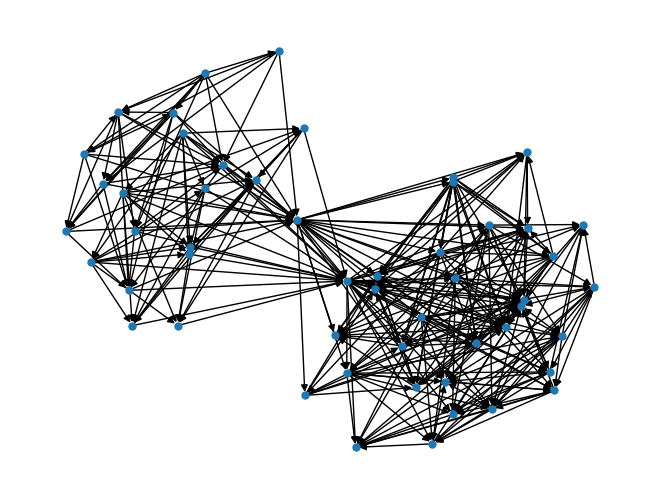

In [26]:
### Parameters for B_hub
num_hub = 2 # same number of upper and lower blocks
s_B = 0.8
B_value_min = -1
B_value_max = 1

size_up_block = 15
size_low_block = 10
intersect_prop = 0.3
p = num_hub + num_hub * (size_up_block + size_low_block)
f"{p=}"

b = np.random.uniform(-5,5,p)  # intercept

B_unscaled = B_hub_func(num_hub, size_up_block, size_low_block, intersect_prop, s_B, B_value_min, B_value_max)

################ Rescale B, but keep its support, so that the variance of X is close to the given one 
var_err_min = 1
var_err_max = 2
var_X_min = 5
var_X_max = 10

sigma2_error_raw = np.random.uniform(var_err_min, var_err_max, p) # rep(var_error,p) # do not make error variance the same!
var_X_design = np.random.uniform(var_X_min, var_X_max, p)  # preset variance of X we want to get based on the SEM
B_raw, sigma2_error_new = rescale_B_func(B_unscaled, var_X_design, sigma2_error_raw, tol=5, step_size=0.0001, max_count=300)

# # check that we indeed make the variance of X similar to the preset one
I = np.identity(p)
var_X_Braw = np.diag( np.dot( linalg.solve(I - B_raw, np.diag(sigma2_error_raw)), linalg.inv(I - B_raw).T ) ) 
print(np.round(var_X_Braw - var_X_design,0))

# Permute B and sigma2_error so that they are not in the causal ordering
ordering = np.random.permutation(np.arange(p))

Permut_mat = np.eye(p)[ordering]  
B = Permut_mat @ B_raw @ Permut_mat.T 
sigma2_error = np.diag(sigma2_error_raw[ordering])

G = nx.DiGraph(B!=0)
nx.draw_kamada_kawai(G, with_labels=False, node_size=25)

In [27]:
n = 200
m = 100
int_mean = 20
int_sd = 1
X_obs, X_int, RC = generate_data(n, m, p, B, sigma2_error, b, int_mean, int_sd)

In [28]:
print(X_obs.shape, X_int.shape)

(200, 52) (100, 52)


In [29]:
obs_data = X_obs
Xobs = X_obs
intv_data = X_int
Xint = X_int
Zscores = zscore(obs_data, intv_data)

In [30]:
#print(np.round(Zscores, 1))
max_index_Zscore = [np.argmax(Zscores[i,:]) for i in range(Zscores.shape[0])]

In [31]:
np.random.seed(2024)
threshold = 1
CholeskyScores = np.zeros((X_int.shape))
for i in tqdm(range(X_int.shape[0])):
    CholeskyScores[i,:] = root_cause_discovery_one_subject_all_perm(Xobs, X_int[i,:], threshold, nshuffles=5, verbose=False)

100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 12.60it/s]


In [32]:
#print(np.round(CholeskyScores, 1))
max_index_Chol = [np.argmax(CholeskyScores[i,:]) for i in range(CholeskyScores.shape[0])]

In [33]:
num_success_Zscore = sum(x == y for x, y in zip(max_index_Zscore, RC))
num_success_Chol = sum(x == y for x, y in zip(max_index_Chol, RC))
print(num_success_Zscore, num_success_Chol)

# df = pd.DataFrame({"RC":RC, "Zscore": max_index_Zscore, "Chol": max_index_Chol})
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# print(df.to_string(index=False))

85 99
